In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/Users/baduk/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/baduk/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Cartpole

In [2]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [3]:
class Network(nn.Module):
    def __init__(self, layer_size=256):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, layer_size)
        self.l2 = nn.Linear(layer_size, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [4]:
def plot_durations(xs, labels):
    plt.figure(figsize=(10, 5))
    plt.xlabel('Номер эпизода')
    plt.ylabel('Число шагов')
    for i,x in enumerate(xs):
        plt.plot(x, label=labels[i])
    plt.legend(loc="upper left")

In [5]:
class CartpoleDQN():
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        self.model = Network()
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0

    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(2)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        state, num_step = self.env.reset(), 0
        while True:
            if render:
                self.env.render()

            state_tensor = torch.tensor([state], dtype=torch.float32)
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
            next_state, reward, done, _ = self.env.step(action.numpy()[0][0])
            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

            if done:
                reward = -1

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            state = next_state
            num_step += 1

            if done:
                print("\tepisode %d finished after %d steps" % (e, num_step))
                self.episode_durations.append(num_step)
                break

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [110]:
m = Network()
a=m(torch.ones((128, 4)))
a.gather(1, batch_action)

tensor([[0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1405, 0.4922],
        [0.1

In [6]:
dqn = CartpoleDQN()

print("%s\tStarting training for 300 episodes..." % (datetime.now().time()))
for e in range(300):
    dqn.run_episode(e)
print("%s\t\t...done!" % (datetime.now().time()))

17:01:13.720275	Starting training for 300 episodes...
	episode 0 finished after 21 steps
	episode 1 finished after 13 steps
	episode 2 finished after 25 steps
	episode 3 finished after 36 steps
	episode 4 finished after 28 steps
	episode 5 finished after 15 steps
	episode 6 finished after 13 steps
	episode 7 finished after 11 steps
	episode 8 finished after 14 steps
	episode 9 finished after 10 steps
	episode 10 finished after 16 steps
	episode 11 finished after 13 steps
	episode 12 finished after 10 steps
	episode 13 finished after 16 steps
	episode 14 finished after 9 steps
	episode 15 finished after 12 steps
	episode 16 finished after 9 steps
	episode 17 finished after 10 steps
	episode 18 finished after 10 steps
	episode 19 finished after 15 steps
	episode 20 finished after 10 steps
	episode 21 finished after 12 steps
	episode 22 finished after 18 steps
	episode 23 finished after 68 steps
	episode 24 finished after 51 steps
	episode 25 finished after 38 steps
	episode 26 finished a

	episode 220 finished after 200 steps
	episode 221 finished after 200 steps
	episode 222 finished after 200 steps
	episode 223 finished after 161 steps
	episode 224 finished after 200 steps
	episode 225 finished after 55 steps
	episode 226 finished after 200 steps
	episode 227 finished after 167 steps
	episode 228 finished after 135 steps
	episode 229 finished after 149 steps
	episode 230 finished after 63 steps
	episode 231 finished after 161 steps
	episode 232 finished after 175 steps
	episode 233 finished after 187 steps
	episode 234 finished after 200 steps
	episode 235 finished after 140 steps
	episode 236 finished after 185 steps
	episode 237 finished after 200 steps
	episode 238 finished after 135 steps
	episode 239 finished after 200 steps
	episode 240 finished after 169 steps
	episode 241 finished after 200 steps
	episode 242 finished after 143 steps
	episode 243 finished after 171 steps
	episode 244 finished after 157 steps
	episode 245 finished after 155 steps
	episode 246 f

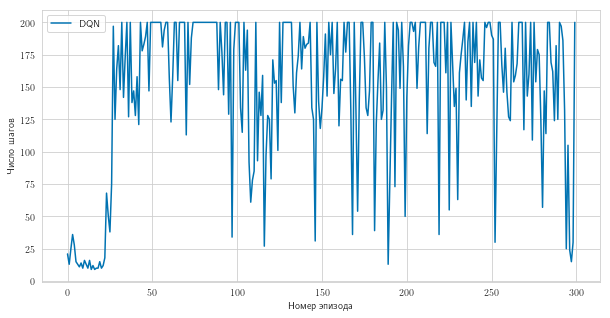

In [107]:
plot_durations([dqn.episode_durations], ['DQN'])

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, layer_size=256):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, layer_size)
        self.l2 = nn.Linear(layer_size, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x), dim=1)
        return x

In [ ]:
class CartpolePolicyGradient():
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        self.model = PolicyNetwork()
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        
    def discount_rewards(self, r):
        '''выдаём дисконтированные награды'''
        discounted_r = torch.zeros(r.size())
        running_add = 0
        for t in reversed(range(len(r))):
            running_add = running_add * self.gamma + r[t]
            discounted_r[t] = running_add

        return discounted_r

    def run_episode(self, e=0):
        state = self.env.reset()
        reward_sum = 0
        xs = torch.tensor([], dtype=torch.float32)
        ys = torch.tensor([], dtype=torch.float32)
        rewards = torch.tensor([], dtype=torch.float32)
        num_step = 0

        while True:
            x = torch.tensor([state], dtype=torch.float32)
            xs = torch.cat([xs, x])

            # считаем вероятности действий и выбираем одно из двух
            action_prob = self.model(Variable(x))
            action = 0 if random.random() < action_prob.data[0][0] else 1

            y = torch.tensor([[1, 0]] if action == 0 else [[0, 1]], dtype=torch.float32)
            ys = torch.cat([ys, y])

            state, reward, done, _ = self.env.step(action)
            rewards = torch.cat([rewards, torch.tensor([[reward]], dtype=torch.float32)])
            reward_sum += reward
            num_step += 1

            if done or num_step >= 500:
                # считаем дисконтированные награды
                targets = self.discount_rewards(rewards)
                
                # нормализуем награды (это baseline)
                targets = (targets - targets.mean())/(targets.std() + 1e-6)
                
                loss = self.learn(xs, ys, targets)
                print("\tepisode %d finished after %d steps" % (e, num_step))
                self.episode_durations.append(num_step)
                break

    def learn(self, x, y, targets):
        # предсказания вероятностей действий
        action_pred = self.model(Variable(x))
        y = Variable(y, requires_grad=True)
        targets = Variable(targets)
        log_lik = -y * torch.log(action_pred)
        log_lik_adv = log_lik * targets
        loss = torch.sum(log_lik_adv, 1).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.data

In [ ]:
pg = CartpolePolicyGradient()

print("%s\tStarting training for 300 episodes..." % (datetime.now().time()))
for e in range(300):
    pg.run_episode(e)
print("%s\t\t...done!" % (datetime.now().time()))

In [ ]:
plot_durations([dqn.episode_durations, pg.episode_durations], ['DQN', 'Policy Gradient'])

## Реализуем крестики-нолики

In [5]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [6]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [16]:
env = TicTacToe(n_rows=15, n_cols=15, n_win=5)

In [19]:
env.getEmptySpaces()

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 0,  7],
       [ 0,  8],
       [ 0,  9],
       [ 0, 10],
       [ 0, 11],
       [ 0, 12],
       [ 0, 13],
       [ 0, 14],
       [ 1,  0],
       [ 1,  1],
       [ 1,  2],
       [ 1,  3],
       [ 1,  4],
       [ 1,  5],
       [ 1,  6],
       [ 1,  7],
       [ 1,  8],
       [ 1,  9],
       [ 1, 10],
       [ 1, 11],
       [ 1, 12],
       [ 1, 13],
       [ 1, 14],
       [ 2,  0],
       [ 2,  1],
       [ 2,  2],
       [ 2,  3],
       [ 2,  4],
       [ 2,  5],
       [ 2,  6],
       [ 2,  7],
       [ 2,  8],
       [ 2,  9],
       [ 2, 10],
       [ 2, 11],
       [ 2, 12],
       [ 2, 13],
       [ 2, 14],
       [ 3,  0],
       [ 3,  1],
       [ 3,  2],
       [ 3,  3],
       [ 3,  4],
       [ 3,  5],
       [ 3,  6],
       [ 3,  7],
       [ 3,  8],
       [ 3,  9],
       [ 3, 10],
       [ 3, 11],
       [ 3, 12],
       [ 3, 13

In [7]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

In [9]:
env = TicTacToe(n_rows=15, n_cols=15, n_win=5)

In [15]:
env.curTurn

1

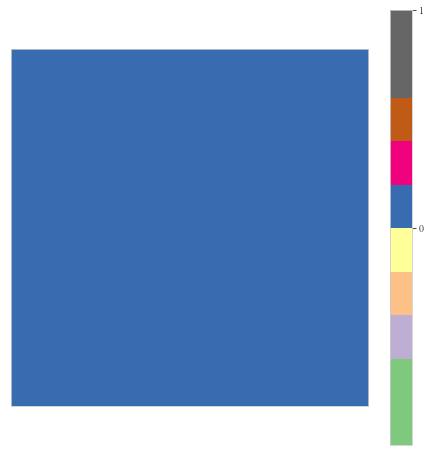

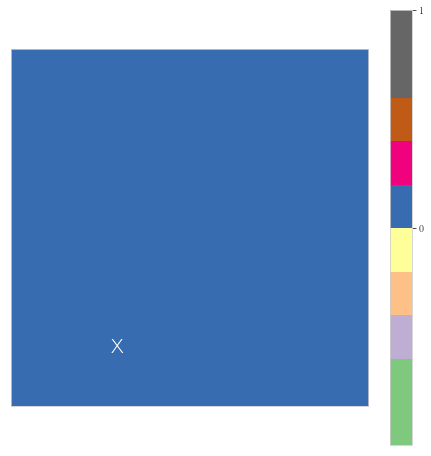

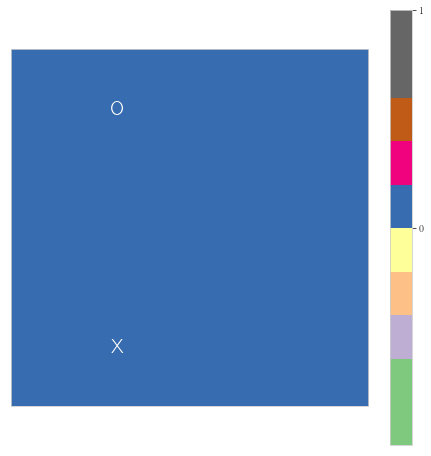

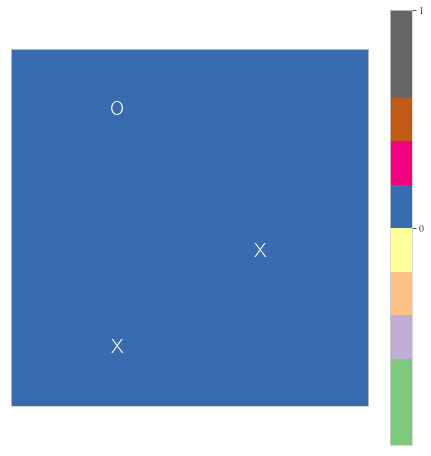

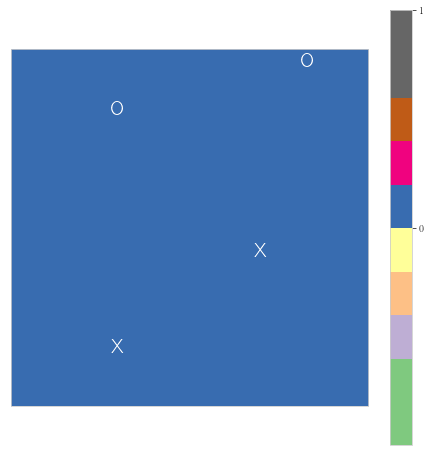

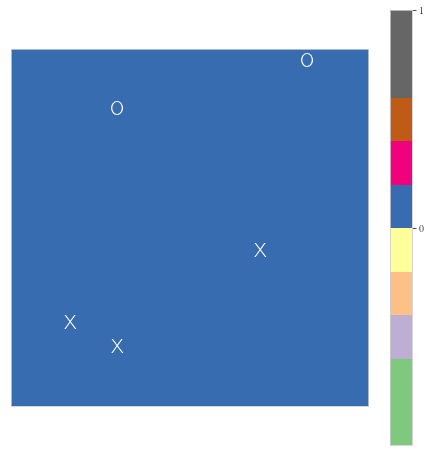

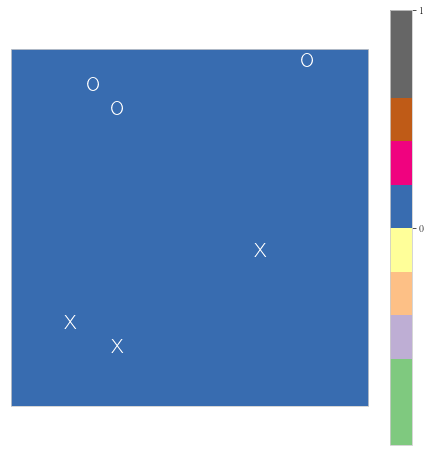

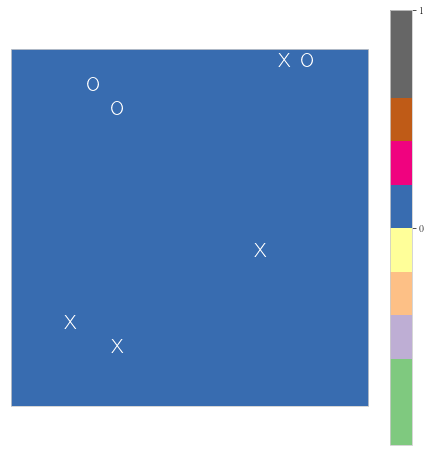

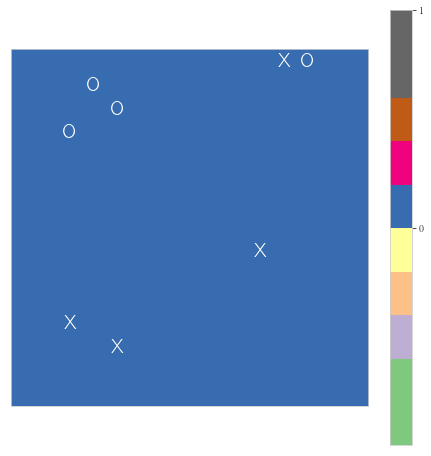

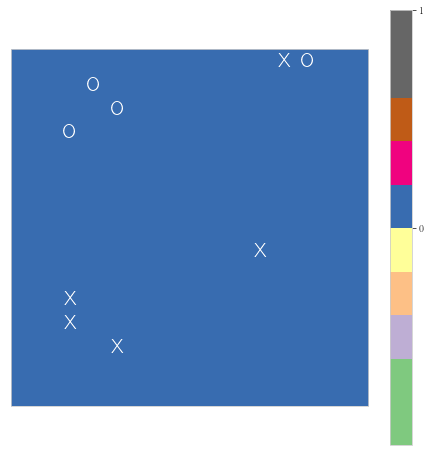

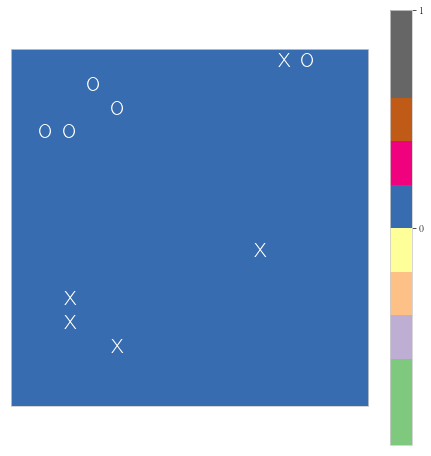

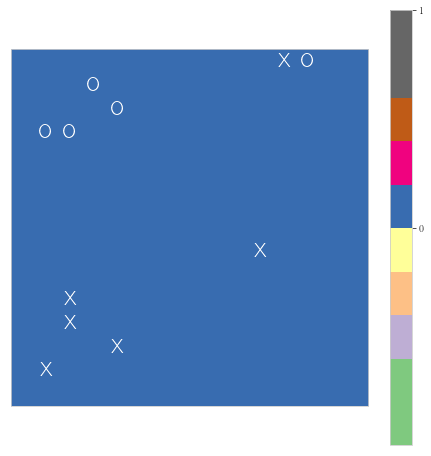

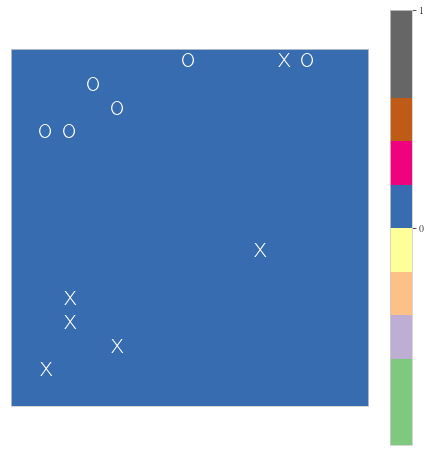

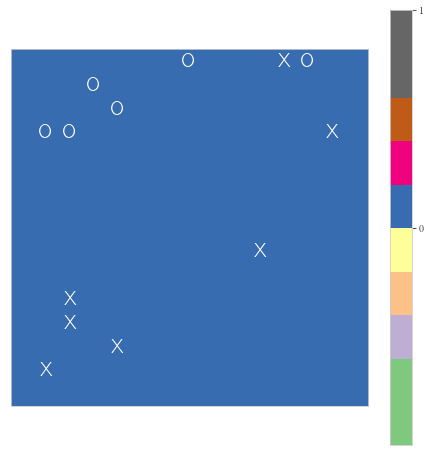

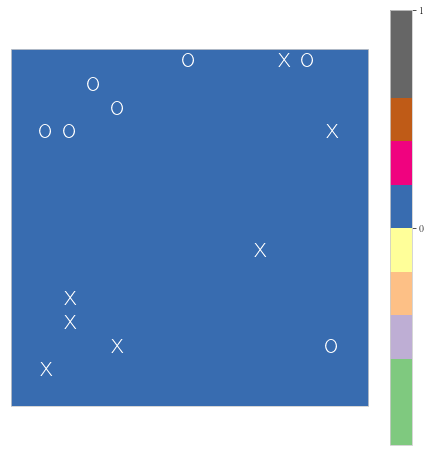

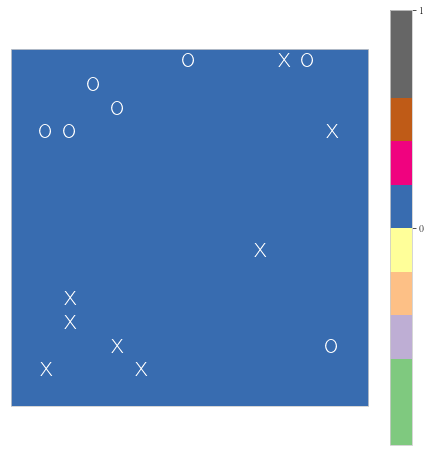

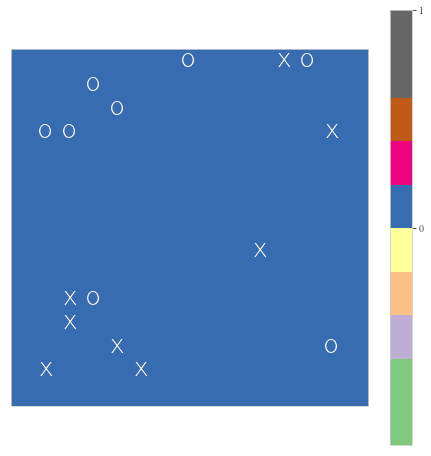

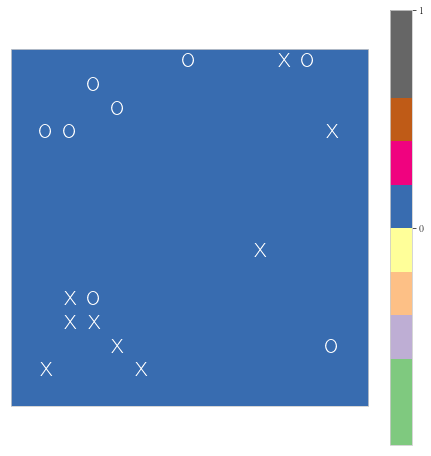

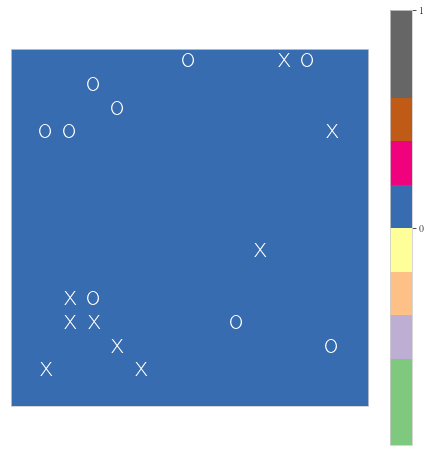

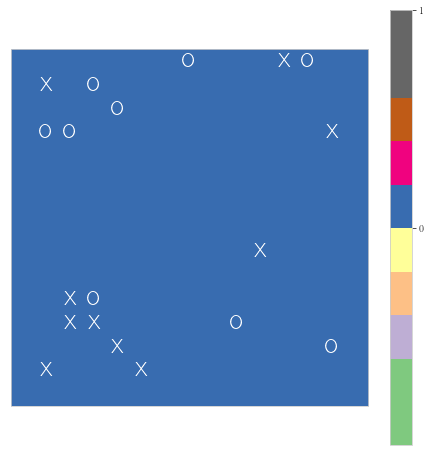

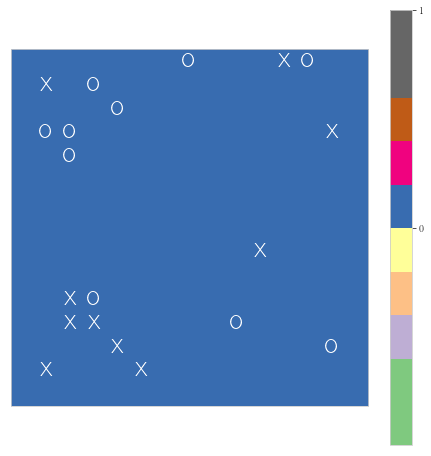

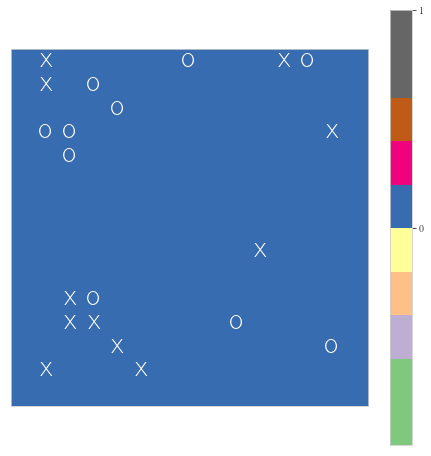

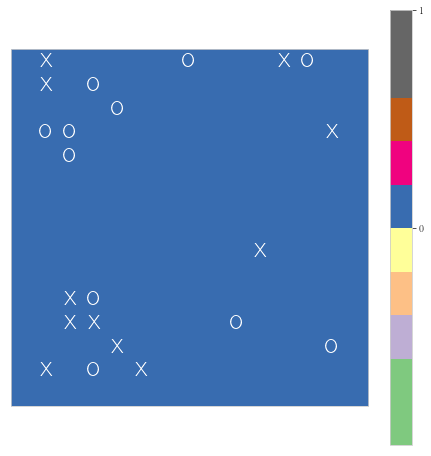

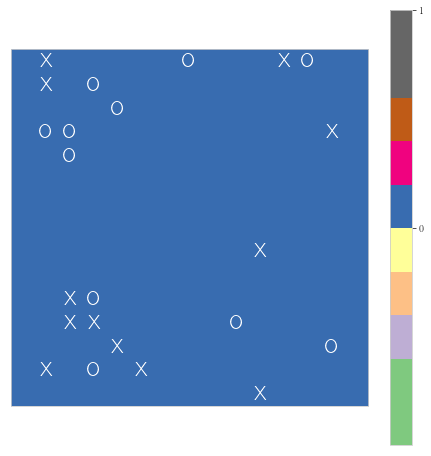

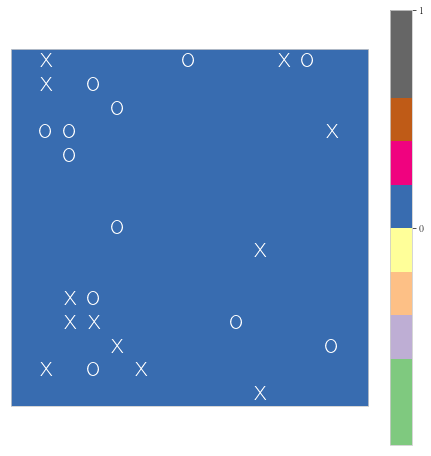

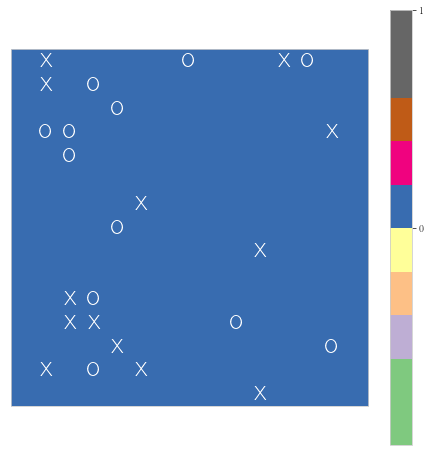

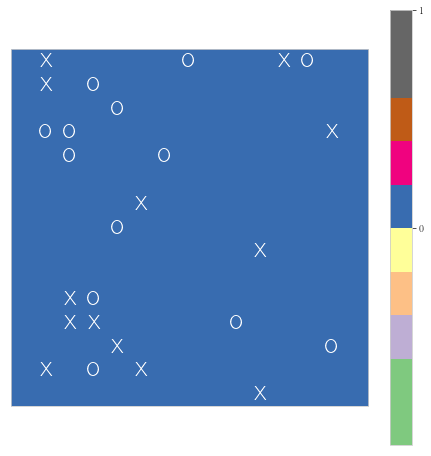

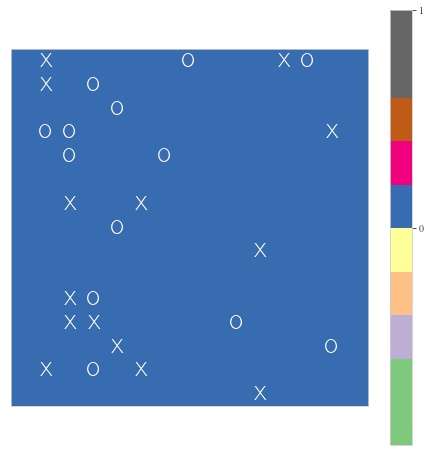

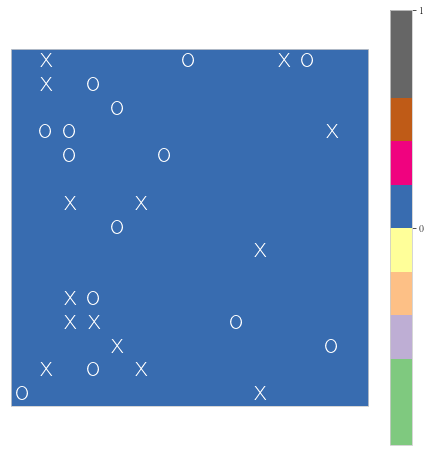

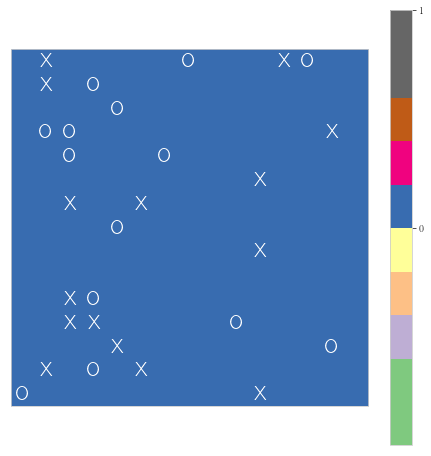

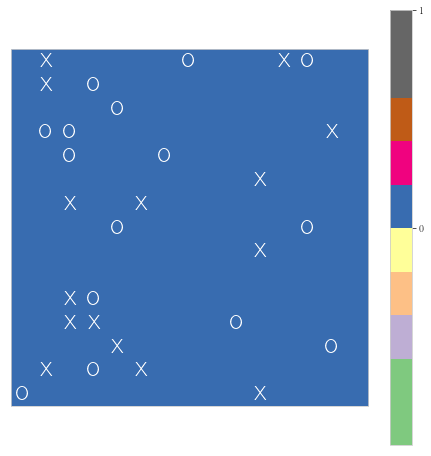

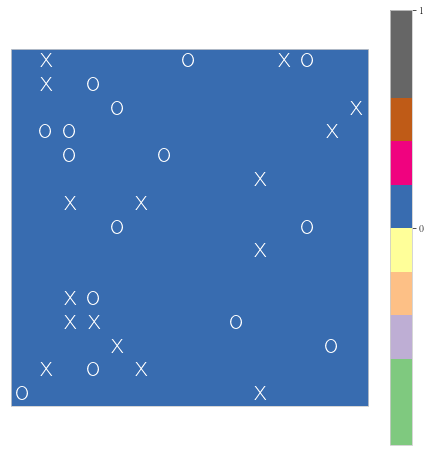

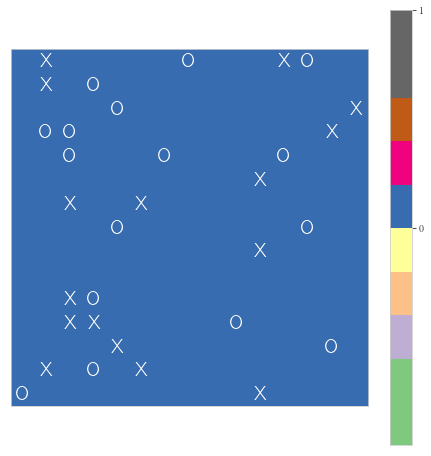

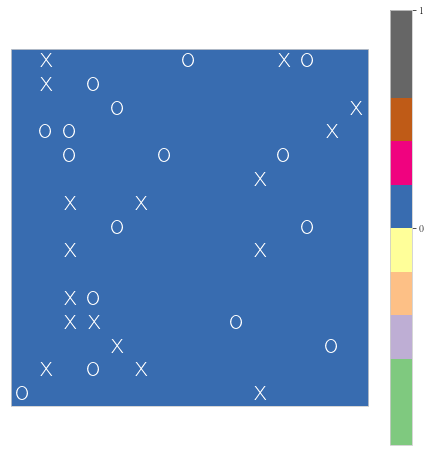

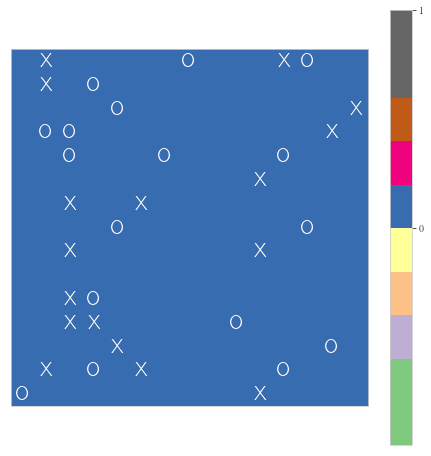

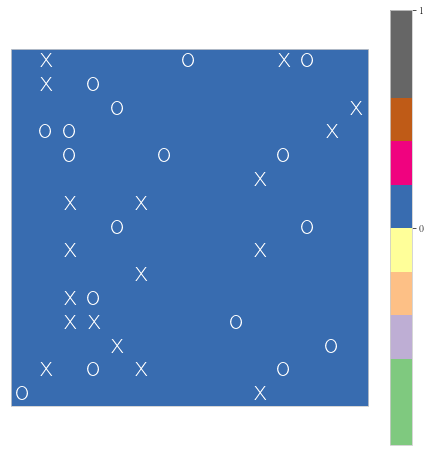

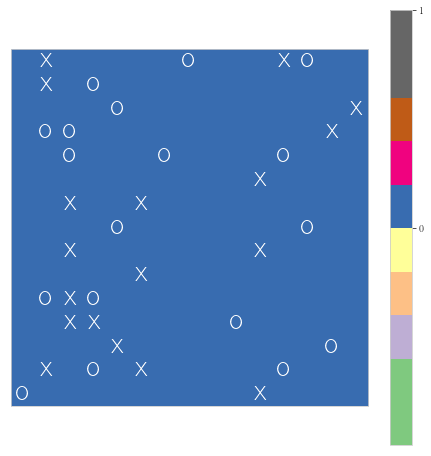

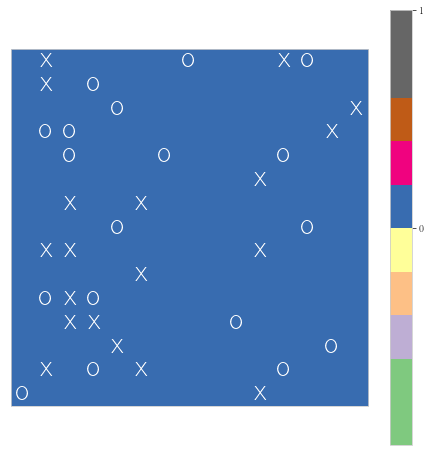

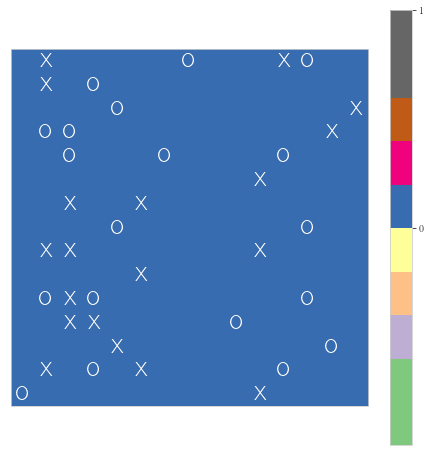

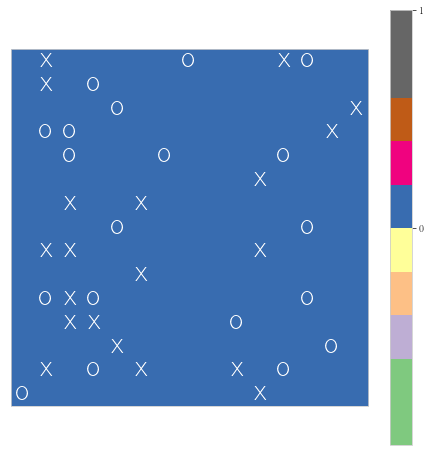

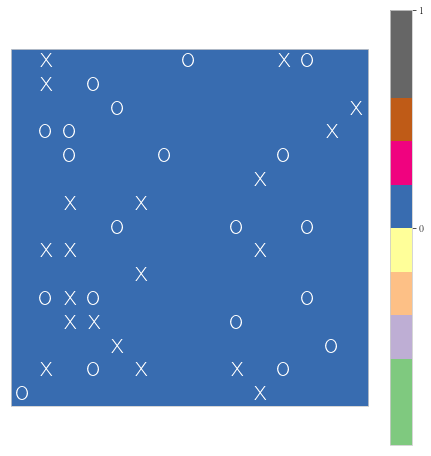

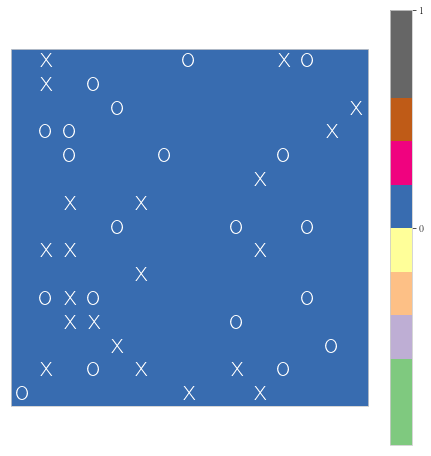

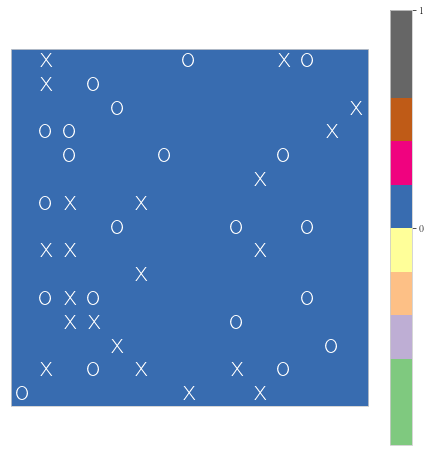

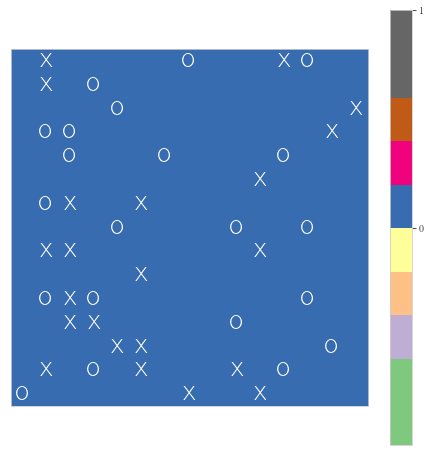

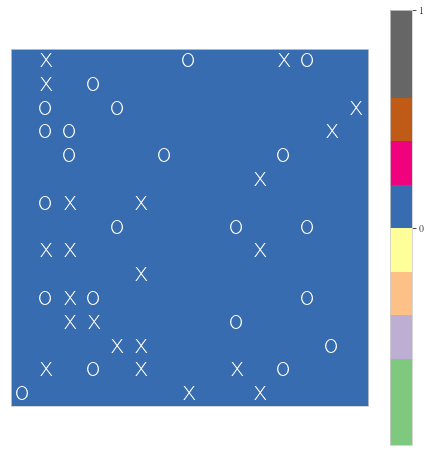

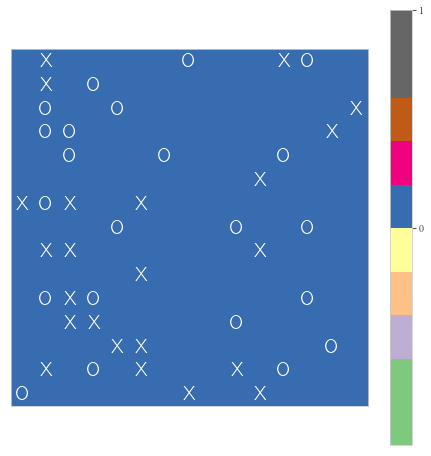

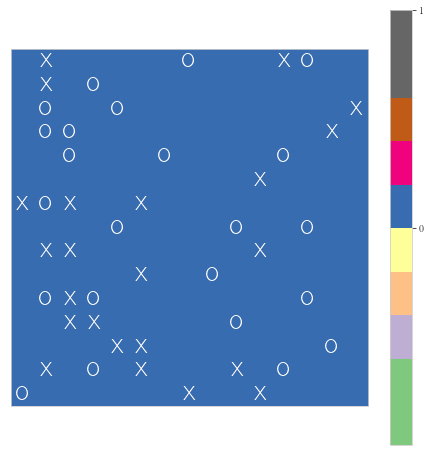

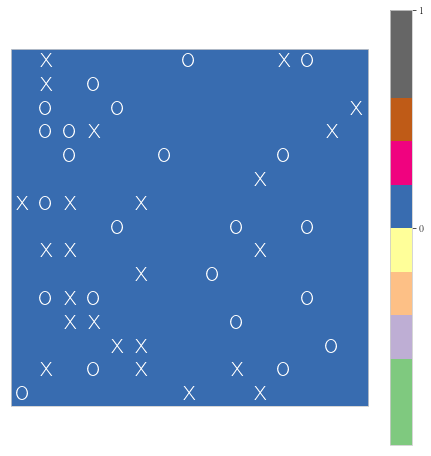

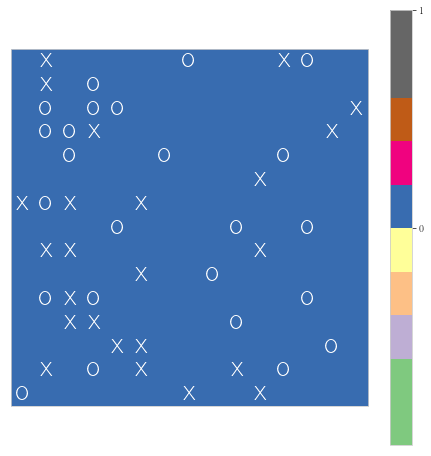

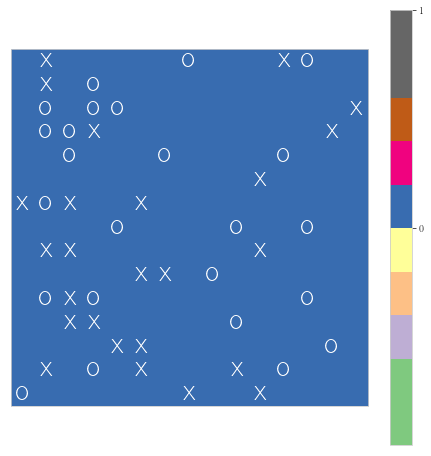

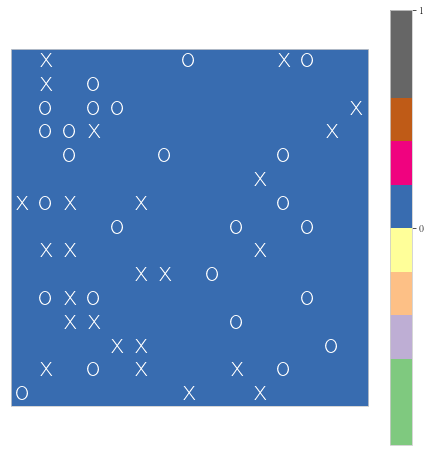

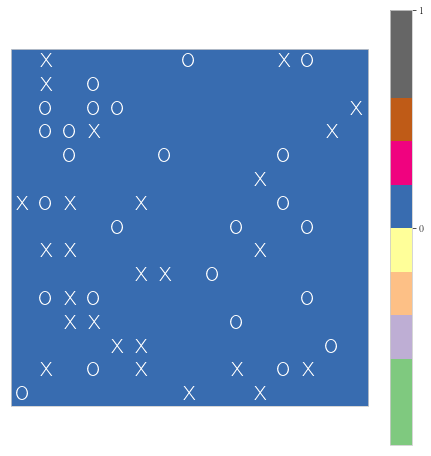

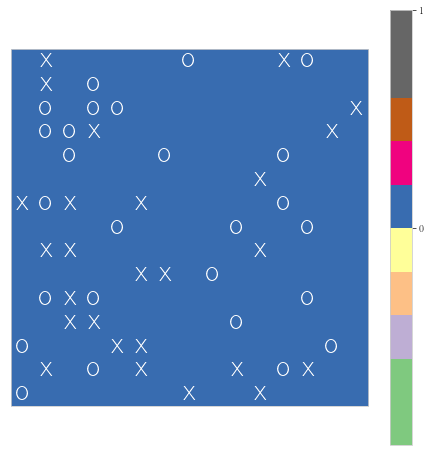

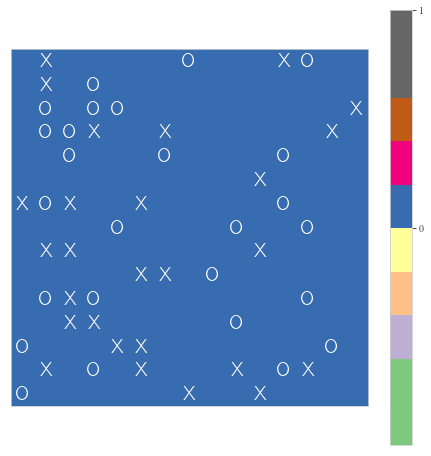

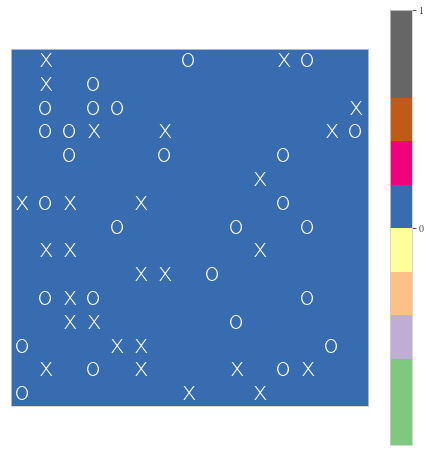

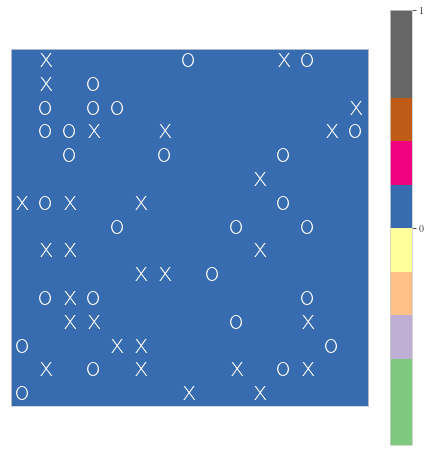

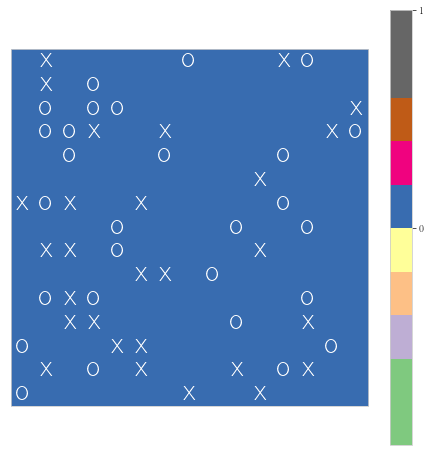

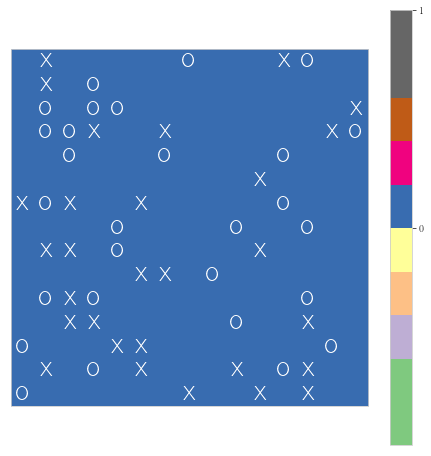

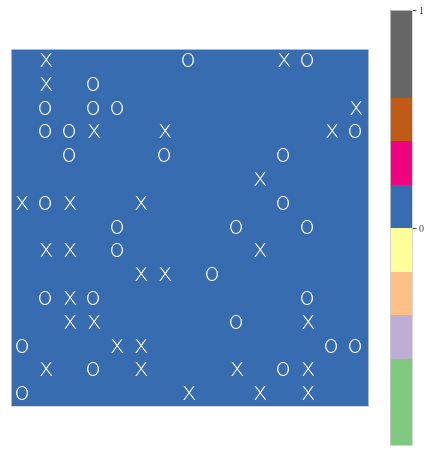

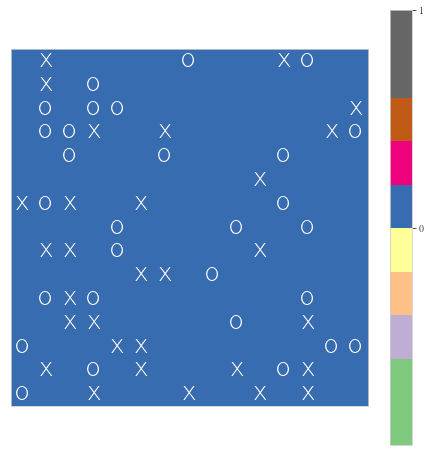

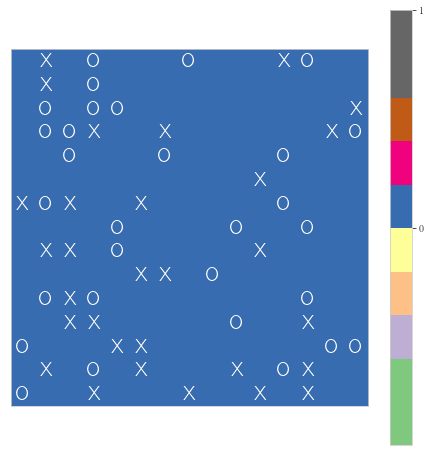

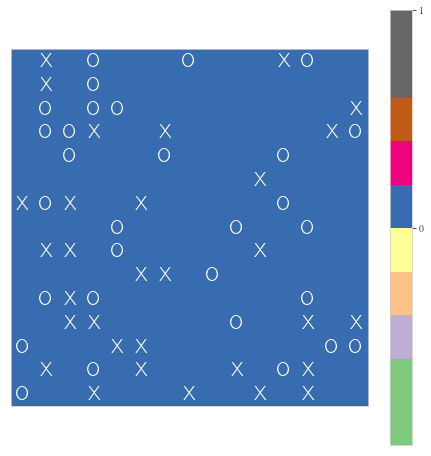

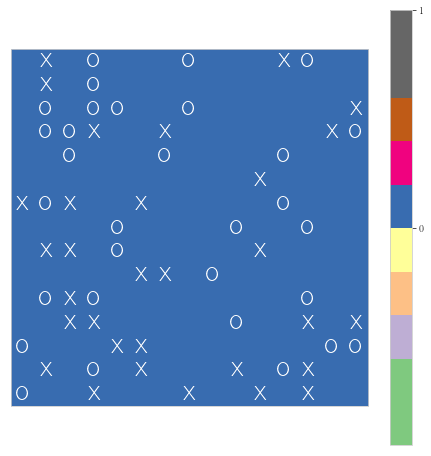

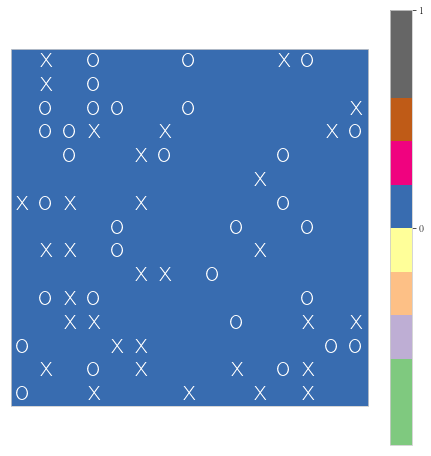

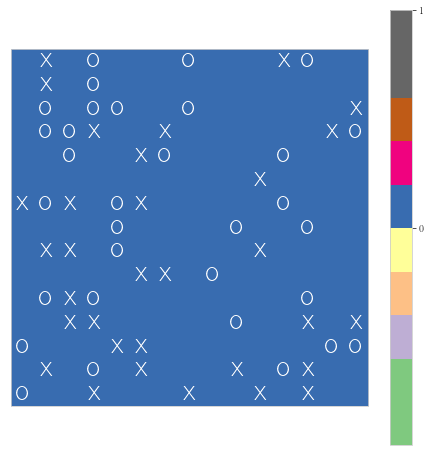

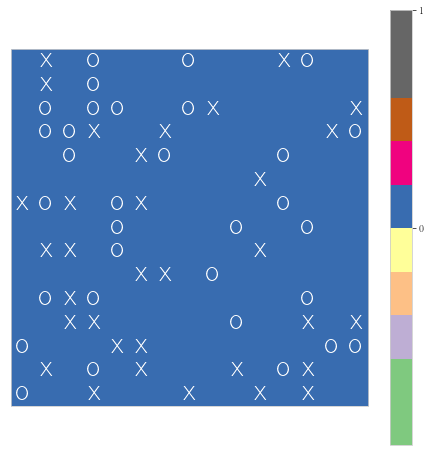

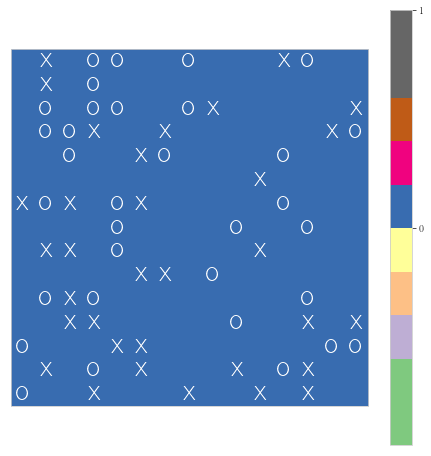

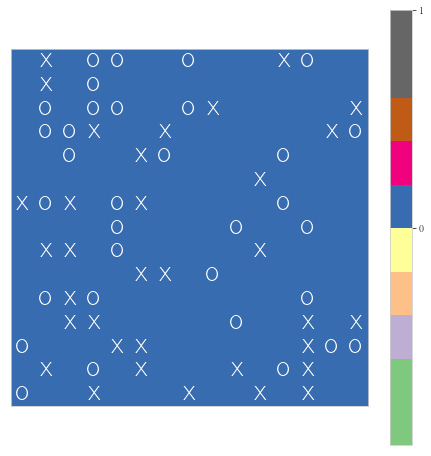

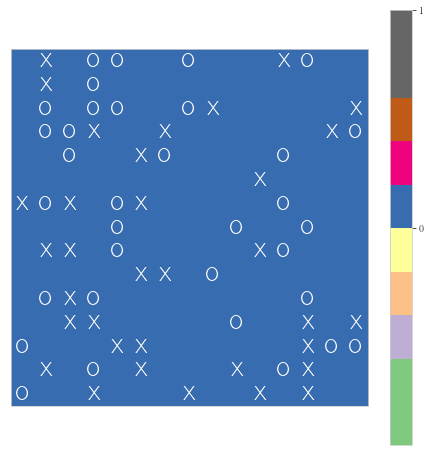

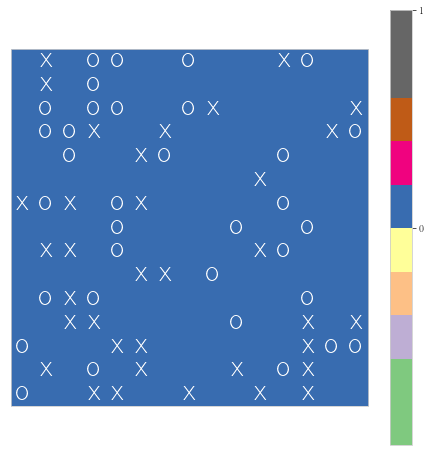

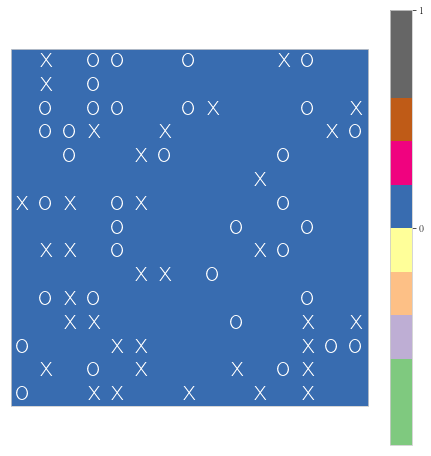

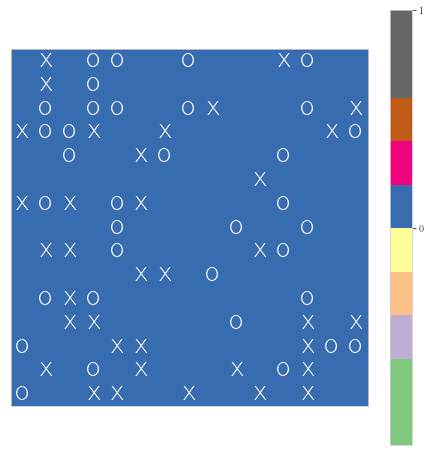

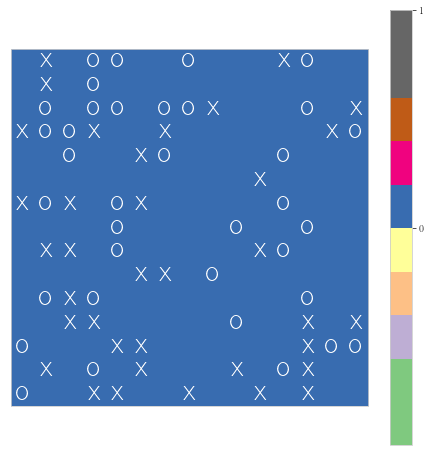

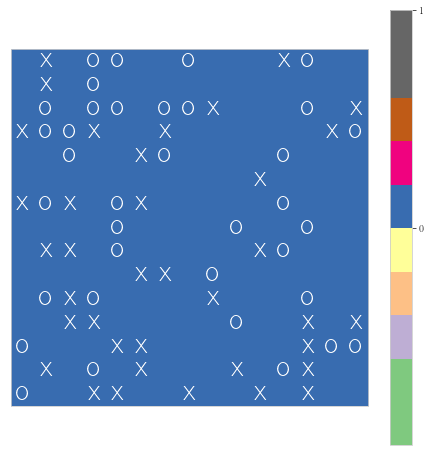

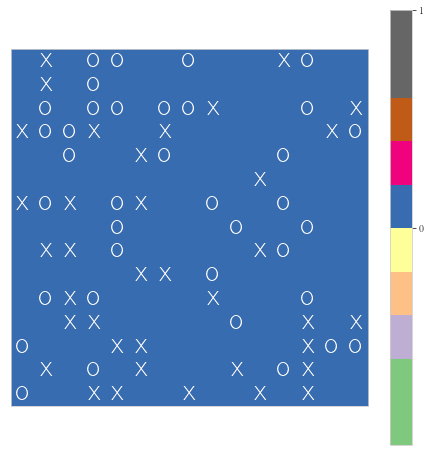

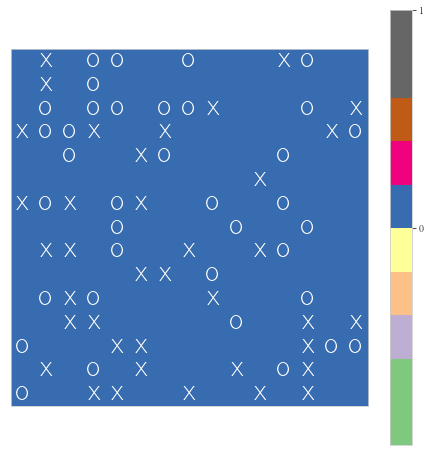

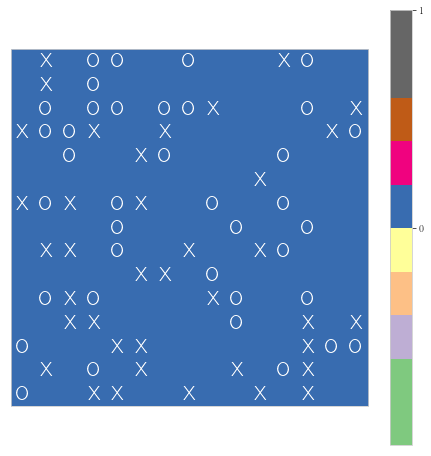

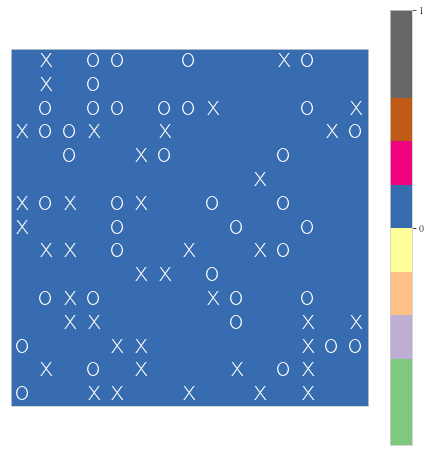

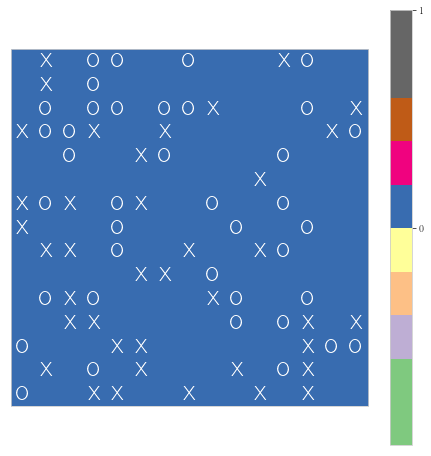

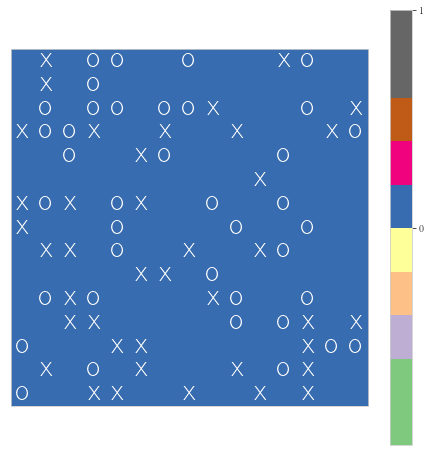

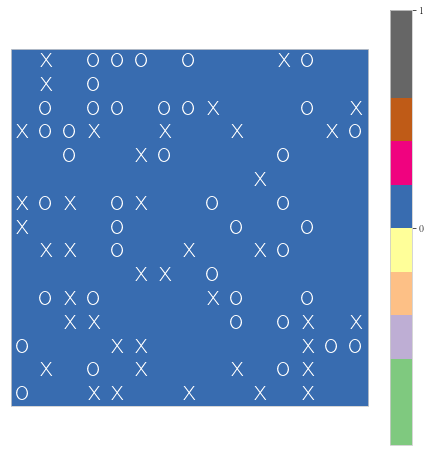

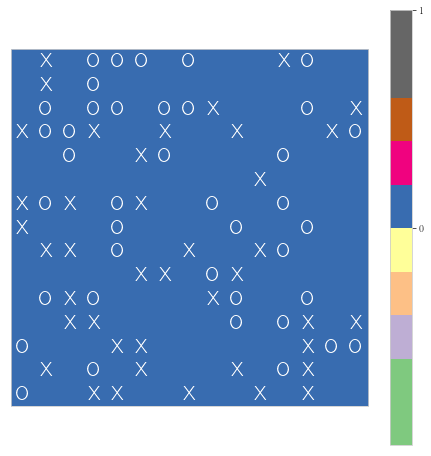

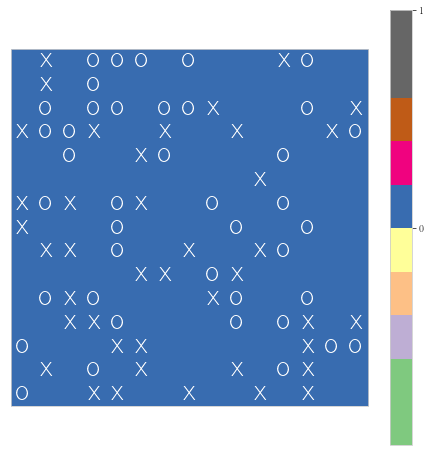

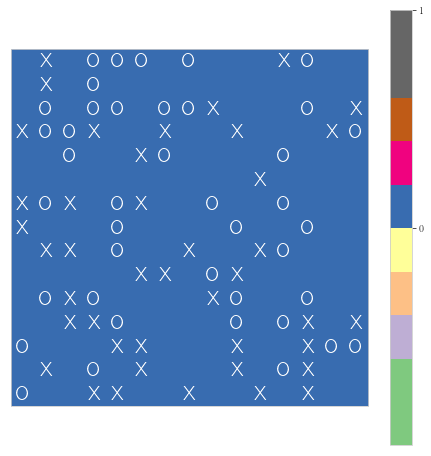

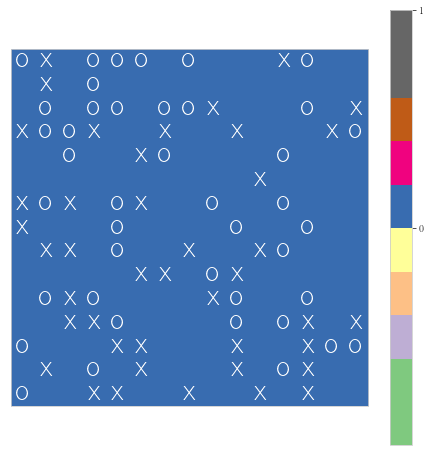

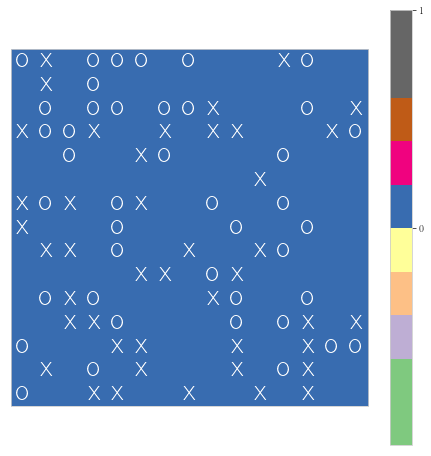

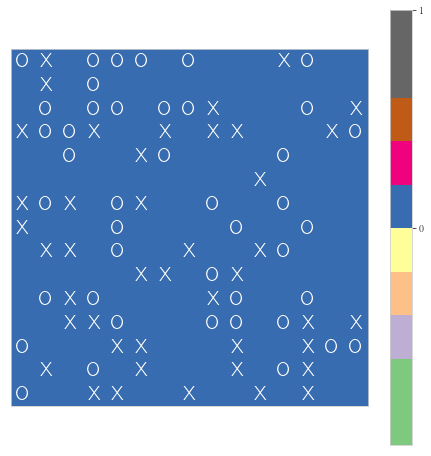

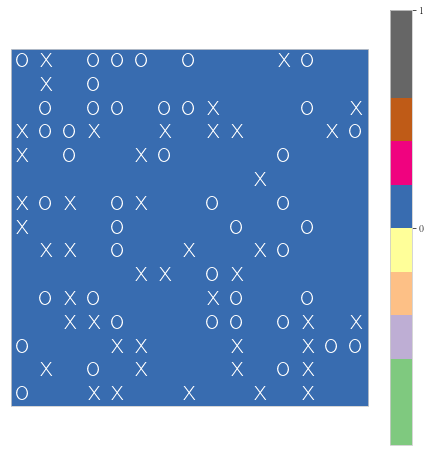

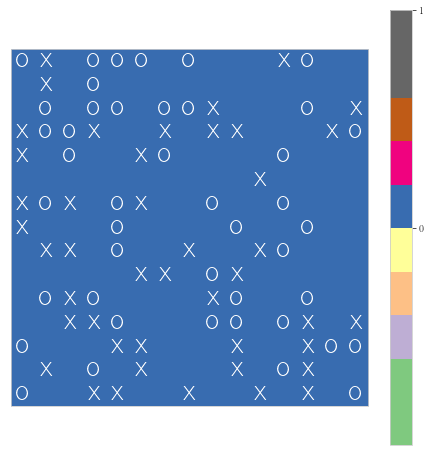

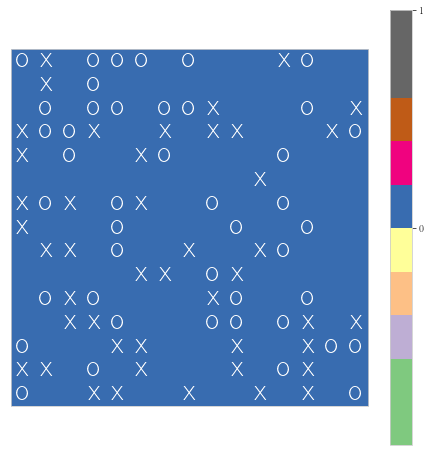

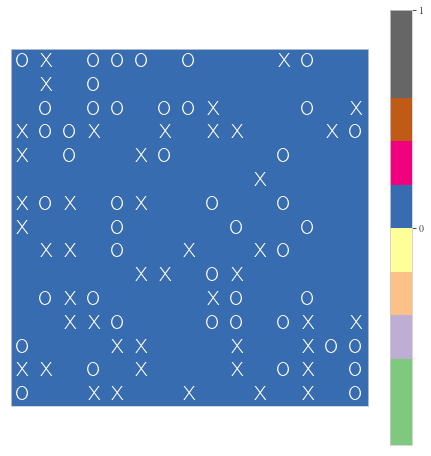

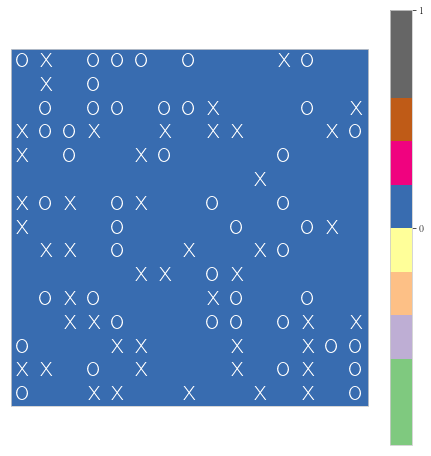

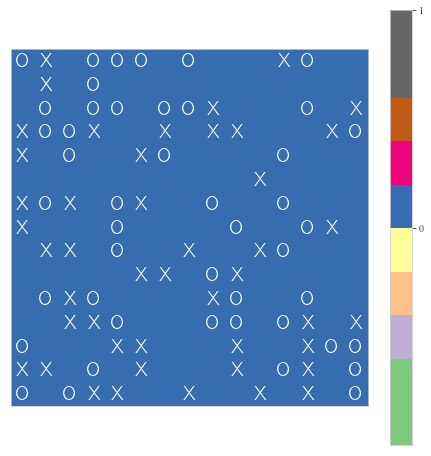

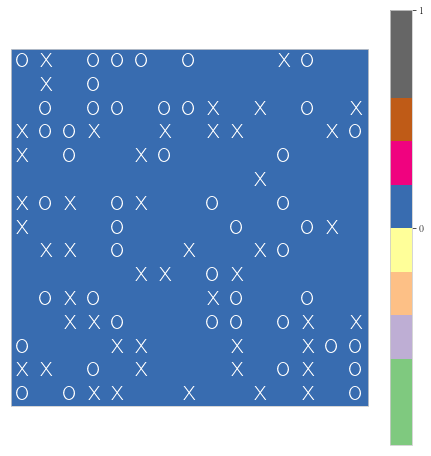

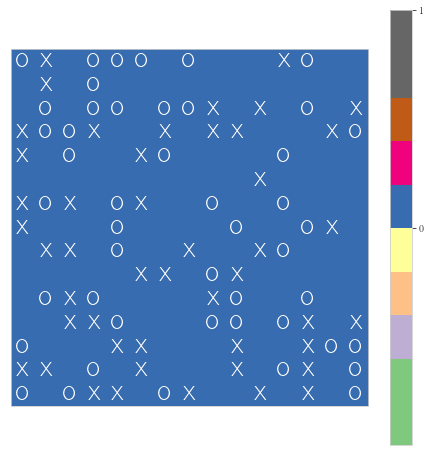

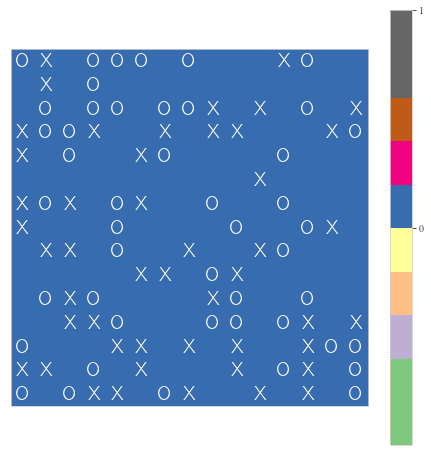

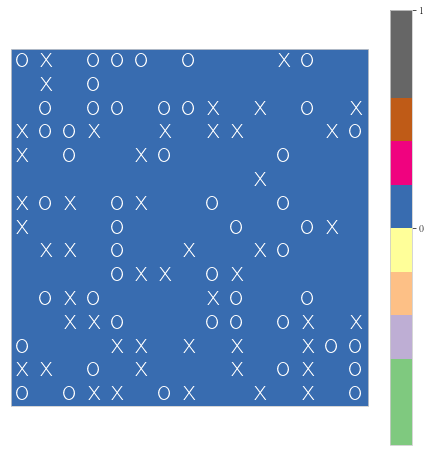

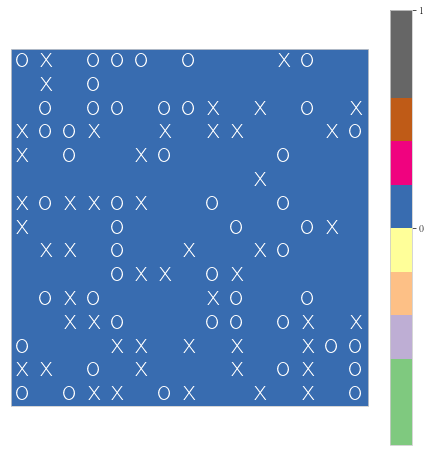

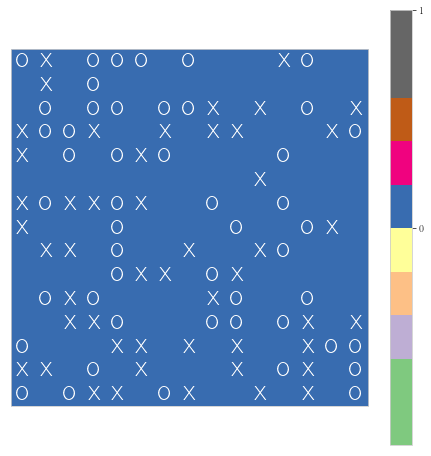

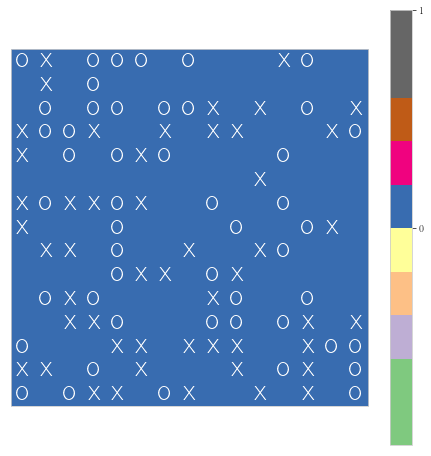

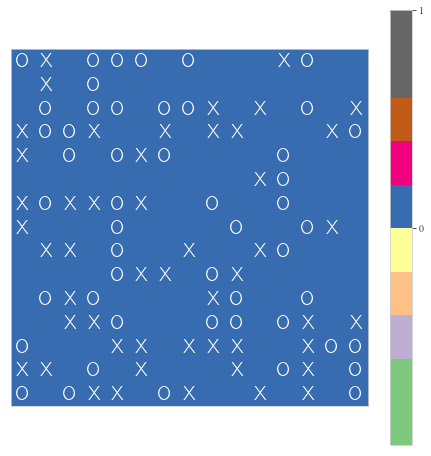

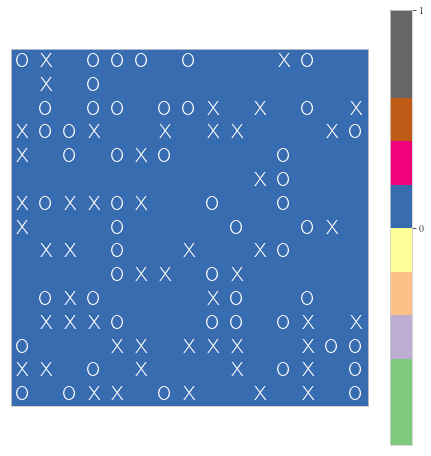

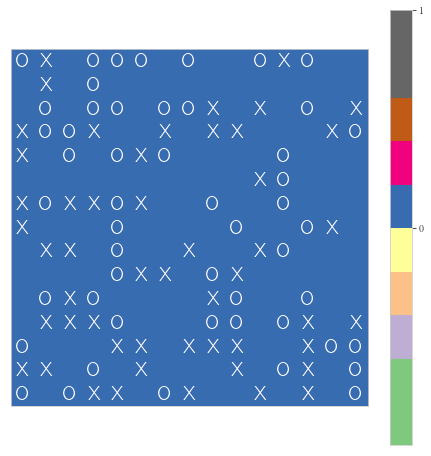

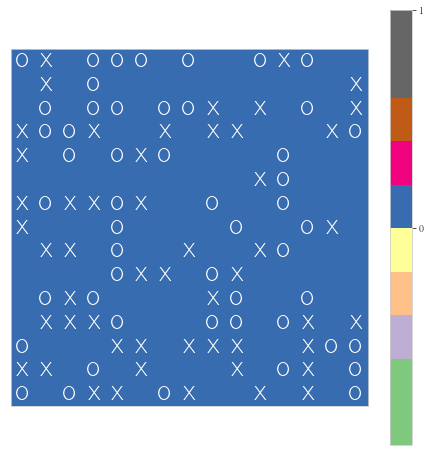

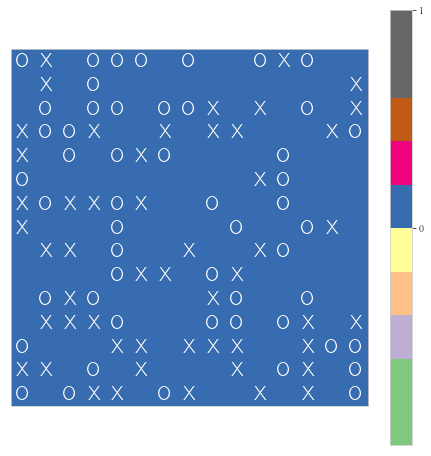

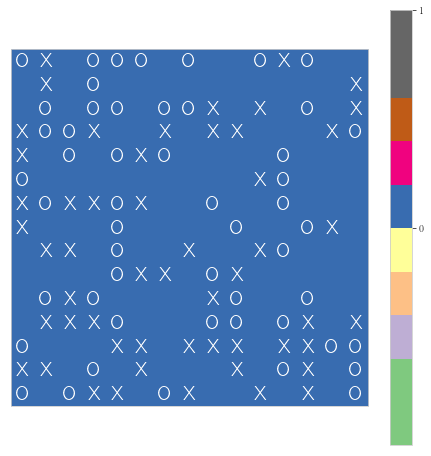

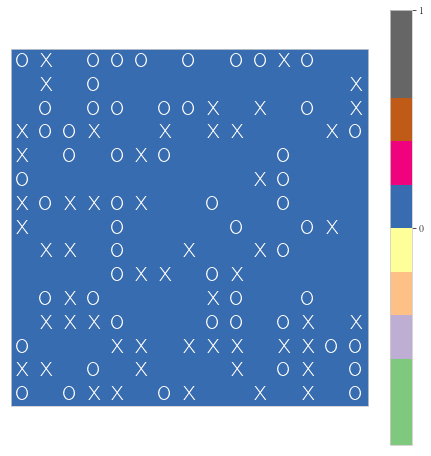

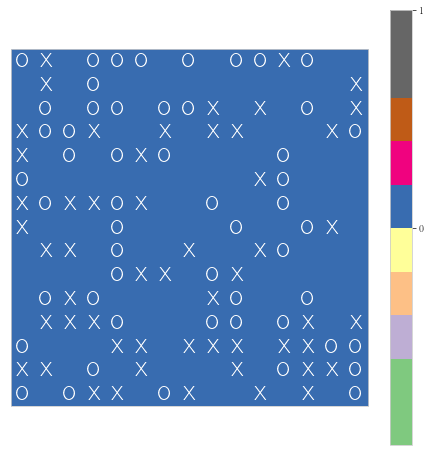

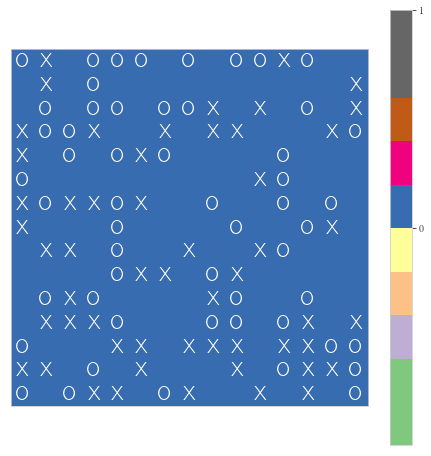

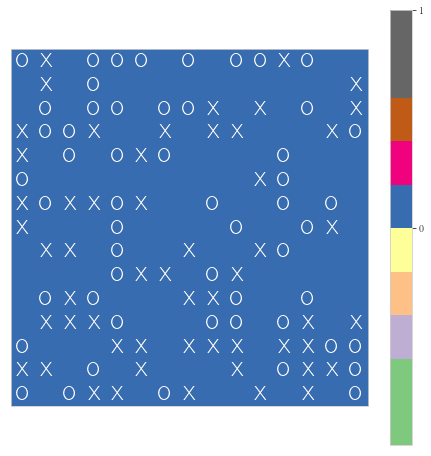

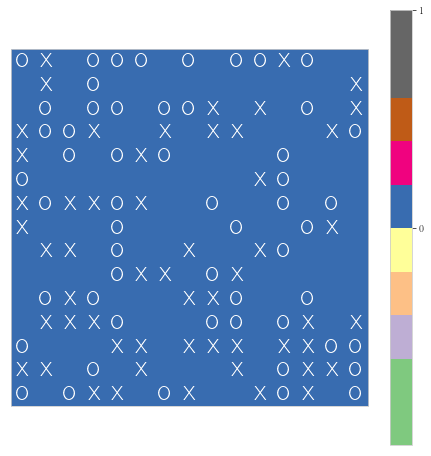

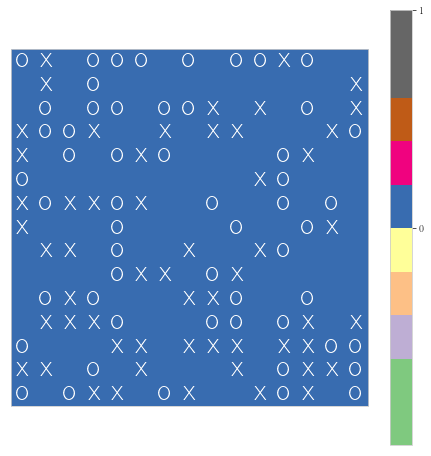

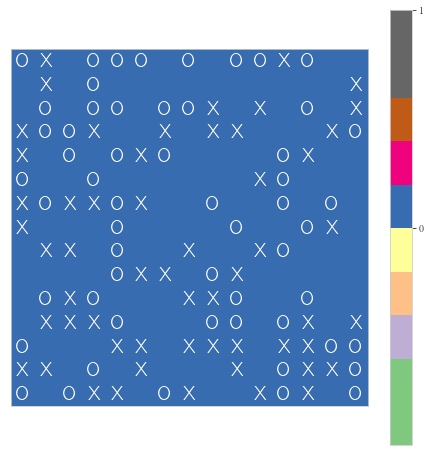

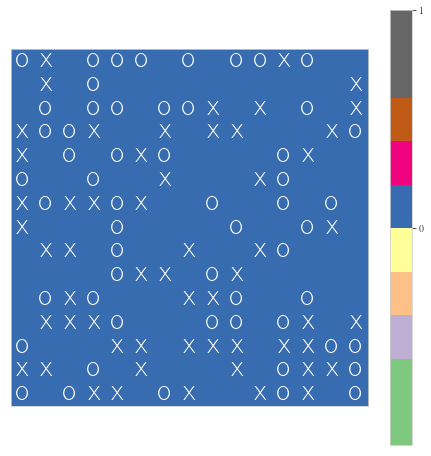

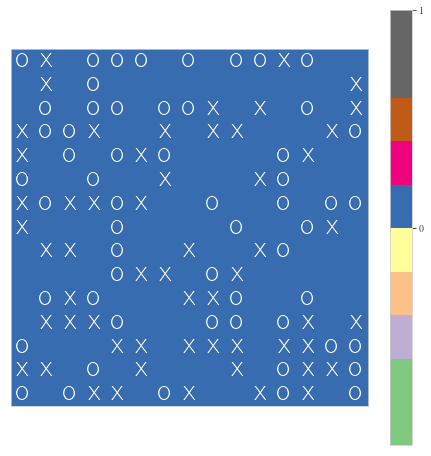

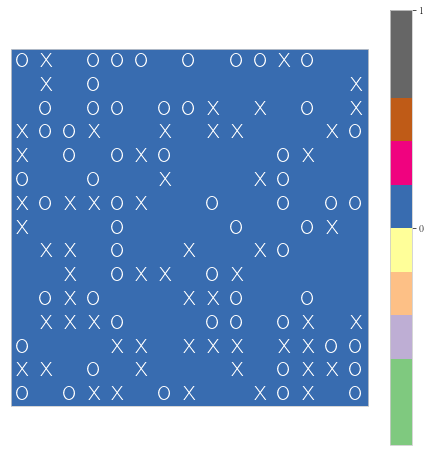

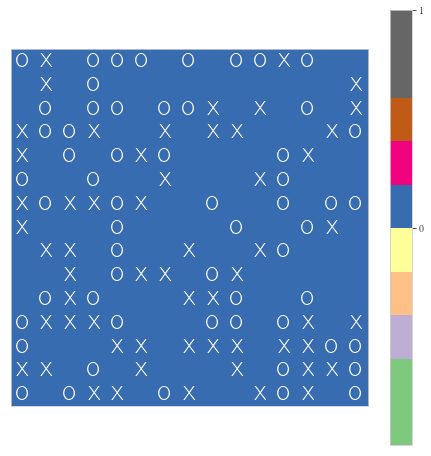

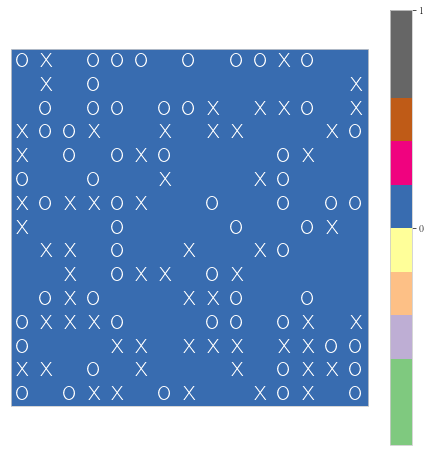

Нолики выиграли!


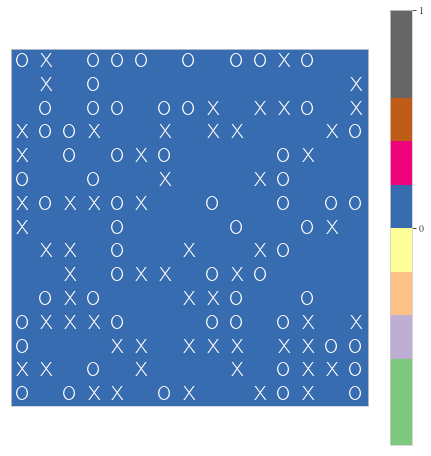

In [6]:
env = TicTacToe(n_rows=15, n_cols=15, n_win=5)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=20)